In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 1: Preprocessing
Look through your data for outliers, perform standardization/normalization and handle missing values.  Use dimensionality reduction if your dataset has a lot of features.+


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_dataset.csv')

def preclassify(row):
    if row['Survival Months'] >= 60 and row['Status'] == 'Alive':
        return 'survived'
    elif row['Survival Months'] < 60 and row['Status'] == 'Dead':  # Assuming there's a 'Dead' status to mark deceased
        return 'not survived'
    else:
        return 'ignore'

# Apply the function to the dataframe
df['preclassified_status'] = df.apply(preclassify, axis=1)
df = df[df['preclassified_status'] != 'ignore']  # Removing 'ignore' class records

# Update the target variable and drop used columns
target = df['preclassified_status']
df = df.drop(['Status', 'Survival Months', 'preclassified_status'], axis=1)


# # Separate features and target variable 'Status'
# target = df['Status']
# df = df.drop('Status', axis=1)

# Separating numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Imputing missing values
# For numeric columns, fill missing values with median
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# For categorical columns, fill missing values with mode (most frequent)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive
0,68.0,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4.0,Positive,Positive,24.0,1.0
1,50.0,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35.0,Positive,Positive,14.0,5.0
2,58.0,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63.0,Positive,Positive,14.0,7.0
3,58.0,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18.0,Positive,Positive,2.0,1.0
5,51.0,White,Single,T1,N1,IIA,Moderately differentiated,2,Regional,20.0,Positive,Positive,18.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,64.0,White,Married,T1,N1,IIA,Moderately differentiated,2,Regional,10.0,Positive,Positive,11.0,1.0
4020,56.0,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46.0,Positive,Positive,14.0,8.0
4021,68.0,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22.0,Positive,Negative,11.0,3.0
4022,58.0,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44.0,Positive,Positive,11.0,1.0


In [ ]:
print(df.columns.tolist())

['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive']


In [ ]:
from sklearn.pipeline import Pipeline

# Encoding Categorical Data
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer(transformers=[('cat', one_hot_encoder, categorical_features)], remainder='passthrough')
df_encoded = transformer.fit_transform(df)
df_encoded

array([[ 0.,  0.,  1., ...,  4., 24.,  1.],
       [ 0.,  0.,  1., ..., 35., 14.,  5.],
       [ 0.,  0.,  1., ..., 63., 14.,  7.],
       ...,
       [ 0.,  0.,  1., ..., 22., 11.,  3.],
       [ 1.,  0.,  0., ..., 44., 11.,  1.],
       [ 0.,  0.,  1., ..., 30.,  7.,  2.]])

In [ ]:
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer."""
    output_features = []

    # Process each transformer in the ColumnTransformer
    for transformer_in_pipeline in column_transformer.transformers_:
        transformer_name, transformer, orig_feature_names = transformer_in_pipeline
        if transformer == 'passthrough':
            # If the transformer is 'passthrough', the feature names are unchanged
            output_features.extend(orig_feature_names)
        elif hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has a 'get_feature_names_out' method, use it
            if isinstance(orig_feature_names, slice):
                # If the feature names are given as a slice (all features for this transformer)
                transformer_features = transformer.get_feature_names_out()
            else:
                # Else, we need to specify feature names (this avoids the boolean context issue)
                transformer_features = transformer.get_feature_names_out(orig_feature_names)
            output_features.extend(transformer_features)
        else:
            # Otherwise, we assume the feature names are unchanged (e.g., for simple transformers)
            output_features.extend(orig_feature_names)

    return output_features

# Make sure to fit the ColumnTransformer on the data before calling this function
transformer.fit(df)
new_features = get_feature_names(transformer)

# Now you can print the new features
print("Transformed features:", new_features)
print("Number of transformed features:", len(new_features))


Transformed features: ['Race_Black', 'Race_Other', 'Race_White', 'Marital Status_Divorced', 'Marital Status_Married', 'Marital Status_Separated', 'Marital Status_Single ', 'Marital Status_Widowed', 'T Stage _T1', 'T Stage _T2', 'T Stage _T3', 'T Stage _T4', 'N Stage_N1', 'N Stage_N2', 'N Stage_N3', '6th Stage_IIA', '6th Stage_IIB', '6th Stage_IIIA', '6th Stage_IIIB', '6th Stage_IIIC', 'differentiate_Moderately differentiated', 'differentiate_Poorly differentiated', 'differentiate_Undifferentiated', 'differentiate_Well differentiated', 'Grade_ anaplastic; Grade IV', 'Grade_1', 'Grade_2', 'Grade_3', 'A Stage_Distant', 'A Stage_Regional', 'Estrogen Status_Negative', 'Estrogen Status_Positive', 'Progesterone Status_Negative', 'Progesterone Status_Positive', 0, 9, 12, 13]
Number of transformed features: 38


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Recalculate information gain with the correct dataset
info_gain = mutual_info_classif(df_encoded, target)

# Create a DataFrame to view information gain by feature
feature_info_gain = pd.DataFrame({'Feature': new_features, 'InfoGain': info_gain})
feature_info_gain.sort_values(by='InfoGain', ascending=False, inplace=True)
print(feature_info_gain)


                                    Feature  InfoGain
37                                       13  0.029637
33             Progesterone Status_Positive  0.027755
32             Progesterone Status_Negative  0.026914
31                 Estrogen Status_Positive  0.021380
19                           6th Stage_IIIC  0.020382
14                               N Stage_N3  0.019967
12                               N Stage_N1  0.014107
27                                  Grade_3  0.011579
35                                        9  0.011509
25                                  Grade_1  0.008955
29                         A Stage_Regional  0.008721
21      differentiate_Poorly differentiated  0.007665
5                  Marital Status_Separated  0.007416
26                                  Grade_2  0.006669
7                    Marital Status_Widowed  0.006450
30                 Estrogen Status_Negative  0.006409
8                               T Stage _T1  0.005931
4                    Marital

In [ ]:
# Print out the lists to verify their contents and structure
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: Index(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive'], dtype='object')
Categorical Features: Index(['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Estrogen Status',
       'Progesterone Status'],
      dtype='object')


In [ ]:
# Convert Index objects to lists
numeric_features_list = numeric_features.tolist()
categorical_features_list = categorical_features.tolist()

# Combine the lists
features = numeric_features_list + categorical_features_list

# Now you can proceed with using 'features' for further processing
print("Combined Features List:", features)


Combined Features List: ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status']


In [ ]:
print(numeric_features)
print(categorical_features)

Index(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive',
       'Survival Months'],
      dtype='object')
Index(['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Estrogen Status',
       'Progesterone Status'],
      dtype='object')


In [ ]:
# Preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Column transformer to allow combining transformations for each type of data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Applying the transformations to the data
df_processed = preprocessor.fit_transform(df)
df_processed

array([[ 1.56525337, -1.25366142,  1.19067633, ...,  1.        ,
         0.        ,  1.        ],
       [-0.44322226,  0.21434515, -0.04409458, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.44943358,  1.54028657, -0.04409458, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.56525337, -0.40127051, -0.41452585, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.44943358,  0.64054061, -0.41452585, ...,  1.        ,
         0.        ,  1.        ],
       [-0.88955017, -0.0224301 , -0.90843421, ...,  1.        ,
         0.        ,  1.        ]])

In [ ]:
if 'sparse' in str(type(df_processed)):
    df_processed = df_processed.toarray()

# Apply PCA
pca = PCA(n_components=0.95) # Adjust n_components as per your requirement
df_reduced = pca.fit_transform(df_processed)
df_reduced

array([[-7.22600440e-01,  1.89173398e+00,  6.58036424e-01, ...,
        -5.29239313e-02, -1.02105244e-01, -1.21353483e-02],
       [ 6.25022051e-01, -4.31950681e-01,  5.66274865e-02, ...,
        -1.57659787e-01, -1.81946890e-03,  1.62792050e-01],
       [ 1.47781982e+00, -3.07475100e-01,  3.40364852e-01, ...,
        -2.59085115e-01,  7.50649151e-01,  3.23419353e-01],
       ...,
       [-6.24465343e-01,  5.53225698e-01,  1.17791336e+00, ...,
        -1.03743153e-01, -1.00731463e-01, -4.47758334e-01],
       [-3.66144701e-01, -6.90500750e-01,  5.20076027e-01, ...,
         8.48414558e-01,  7.96980715e-01,  2.40903307e-01],
       [-9.54717084e-01, -1.04339057e+00, -1.08181721e+00, ...,
        -1.48004086e-01, -1.59560483e-02, -6.48864712e-03]])

#Step 2: Modeling – For this step you can use tools and/or libraries
Apply the Feature Selection and Feature Ranking Techniques we covered in class and/or a combination of both approaches.
Train the following algorithms on your dataset (feel free to experiment with more!) -
1.	KNN (this should be implemented from scratch, do NOT use in-built libraries)
2.	Naïve Bayes
3.	C4.5 Decision Tree
4.	Random Forest
5.	Gradient Boosting
You can experiment with neural networks too and see if you achieve better performance.
NOTE: For each model used, be sure to include a 1-2 line summary as well as the pros and cons of each algorithm and list out its main hyperparameters.


###**KNN**
A non-parametric, lazy learning algorithm that classifies data points based on the majority vote of their neighbors, with the data point being assigned to the class most common among its k nearest neighbors.

####**Pros:**
Simple and easy to implement.
No assumptions about the data distribution (non-parametric). Can be used for classification and regression.

####**Cons:**

Computationally expensive because it stores all the training data.
High memory requirement as it needs to store all the training data.
Sensitive to the scale of the data and irrelevant features.
Performance can significantly decrease with high-dimensional data (curse of dimensionality).

####**Main Hyperparameters:**

**k**: The number of nearest neighbors to consider for the majority vote.
Distance Metric: The method used to calculate the distance between data points, typically Euclidean distance, but can be Manhattan, Minkowski, etc.

**Weights**: Method to weight the contribution of neighbors, either uniform or distance-based.**

In [ ]:
from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    @staticmethod
    def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
target = label_encoder.fit_transform(target)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_reduced, target, test_size=0.2, random_state=42)

# KNN implementation
knn = KNN(k=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

# Predict on the testing data
predictions = knn.predict(X_test)

In [ ]:
# Evaluate predictions
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of KNN: {accuracy*100:.2f}%")

Accuracy of KNN: 87.58%


###**Naive Bayes**###
A probabilistic classifier that applies Bayes' theorem with the "naive" assumption of independence between every pair of features given the class label.

####**Pros:**

It is simple and can be extremely fast compared to more sophisticated methods.
Works well with high-dimensional datasets.
Performs well with categorical input variables compared to numerical variables.
Particularly useful for text classification tasks.

####**Cons:**

The assumption of feature independence is often violated in real-world scenarios, which can limit performance.
It has been known to be a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
It can't learn interactions between features.

####**Main Hyperparameters:**

**var_smoothing**: Portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Fit the Naive-Bayes model on the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict on the testing data
predictions = gnb.predict(X_test)

# Evaluate the predictions using accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of Naive Bayes classifier: {accuracy*100:.2f}%')

Accuracy of Naive Bayes classifier: 87.70%


###**Decision Trees**
A non-parametric supervised learning method used for classification and regression. A decision tree builds the model in the form of a tree structure. It breaks down a dataset into smaller subsets while at the same time developing an associated decision tree incrementally. The final result is a tree with decision nodes and leaf nodes.

####**Pros:**

Simple to understand and interpret.
Can handle both numerical and categorical data.
Requires little data preparation.

####**Cons:**

Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting.
Small variations in the data might result in a completely different tree being generated.
Decision trees can be biased if some classes dominate.

####**Main Hyperparameters:**

**criterion:** The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
**max_depth:** The maximum depth of the tree.
**min_samples_split:** The minimum number of samples required to split an internal node.
**min_samples_leaf:** The minimum number of samples required to be at a leaf node.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree model on the training data
dtc.fit(X_train, y_train)

# Predict on the testing data
predictions = dtc.predict(X_test)

# Evaluate the predictions using accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of Decision Tree classifier: {accuracy*100:.2f}%')

Accuracy of Decision Tree classifier: 84.35%


###**Random Forest**
Builds multiple decision trees and merges them together to get a more accurate and stable prediction.

####**Pros:**

It can handle a large dataset with higher dimensionality.
It performs well on both regression and classification tasks.
It provides a good indicator of feature importance.

####**Cons:**

Overfitting can still occur with noisy datasets.
Unlike decision trees, the classifications made by random forests are difficult for humans to interpret.
For data including categorical variables with different numbers of levels, random forests are biased in favor of those attributes with more levels.
It can be quite slow to create predictions once trained.

####**Main Hyperparameters:**

**n_estimators:** The number of trees in the forest.
**max_depth:** The maximum depth of the trees.
**min_samples_split:** The minimum number of samples required to split an internal node.
**min_samples_leaf:** The minimum number of samples required to be at a leaf node.
**bootstrap:** Whether bootstrap samples are used when building trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Predict on the testing data
predictions = rfc.predict(X_test)

# Evaluate the predictions using accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of Random Forest classifier: {accuracy*100:.2f}%')

Accuracy of Random Forest classifier: 89.57%


###**Gradient Boosting**
Trains many models in a gradual, additive and sequential manner. Each new model gradually minimizes the loss function (usually a loss function like mean squared error) of the whole system using the Gradient Descent method.

####**Pros:**

Often provides predictive accuracy that cannot be trumped.
Lots of flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.
No data pre-processing required - often works great with categorical and numerical values as is.
Handles missing data - imputation not required.

####**Cons:**

GBMs will continue to improve to minimize all errors. This can overemphasize outliers and can overfit.
Computationally expensive - GBMs often require many trees (>1000) which can be time and memory exhaustive.
The high flexibility results in many parameters that interact and will influence the behavior of the approach (creating a high chance of not setting the right parameters).

####**Main Hyperparameters:**

**n_estimators:** The number of boosting stages to be run.
**learning_rate:** Rate at which the contribution of new trees is added to the model.
**max_depth:** Limits the number of nodes in the tree.
**loss:** Loss function to be optimized. 'deviance' (for classification) refers to logistic regression for binary classification with probabilistic outputs.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Fit the model on the training data
gbc.fit(X_train, y_train)

# Predict on the testing data
predictions = gbc.predict(X_test)

# Evaluate the predictions using accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of Gradient Boosting classifier: {accuracy*100:.2f}%')

Accuracy of Gradient Boosting classifier: 88.94%


#Step 3: Hyperparameter Tuning
Pick any 2 of the above algorithms that contain at least 2 hyperparameters and perform a hyperparameter search using either Grid or Random search. Display the performance metrics and conclude which set of hyperparameters worked the best.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

# Setup the GridSearchCV for Random Forest
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       cv=3,
                       scoring='accuracy')

# Setup the GridSearchCV for Gradient Boosting
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                       param_grid=param_grid_gb,
                       cv=3,
                       scoring='accuracy')

# Fit the GridSearchCV models
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

# Results for Random Forest
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best cross-validated accuracy (Random Forest):", grid_rf.best_score_)

# Results for Gradient Boosting
print("Best parameters for Gradient Boosting:", grid_gb.best_params_)
print("Best cross-validated accuracy (Gradient Boosting):", grid_gb.best_score_)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated accuracy (Random Forest): 0.8906492699596148
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best cross-validated accuracy (Gradient Boosting): 0.8863000931966449


#Step 4: Results
Display your results using a table and explain whether you were able to answer your initial question or not. (Note: Points will not be deducted for poor results as long as the processes followed were sound).
If the models you have used allow it, present what were the most important features used in the classification.


In [ ]:
import pandas as pd

# Create data frames for the best parameters and scores
results_rf = pd.DataFrame(grid_rf.cv_results_)
results_gb = pd.DataFrame(grid_gb.cv_results_)

# Display the top few rows of the results for Random Forest
print("Random Forest Results:")
display(results_rf[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

# Display the top few rows of the results for Gradient Boosting
print("Gradient Boosting Results:")
display(results_gb[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())


Random Forest Results:


,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score
11,200,10,5,2,0.890649
2,200,10,2,1,0.890339
32,200,None,2,2,0.890028
23,200,20,5,2,0.890028
8,200,10,2,2,0.890028


Gradient Boosting Results:


,param_n_estimators,param_learning_rate,param_max_depth,mean_test_score
2,200,0.01,3,0.886300
5,200,0.01,5,0.885368
9,50,0.1,3,0.884126
10,100,0.1,3,0.884126
12,50,0.1,5,0.882262


Random Forest Hyperparameter Tuning Heatmap:


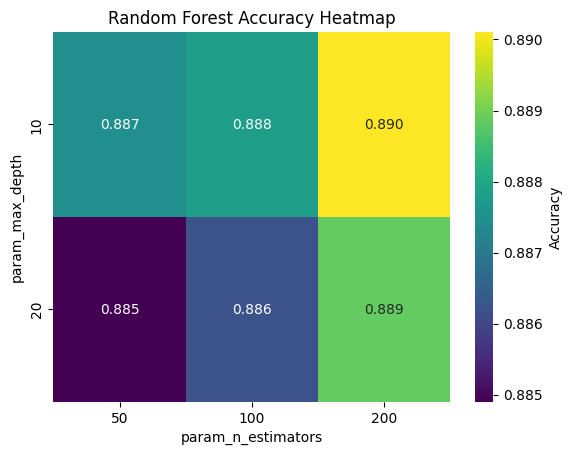

Gradient Boosting Hyperparameter Tuning Heatmap:


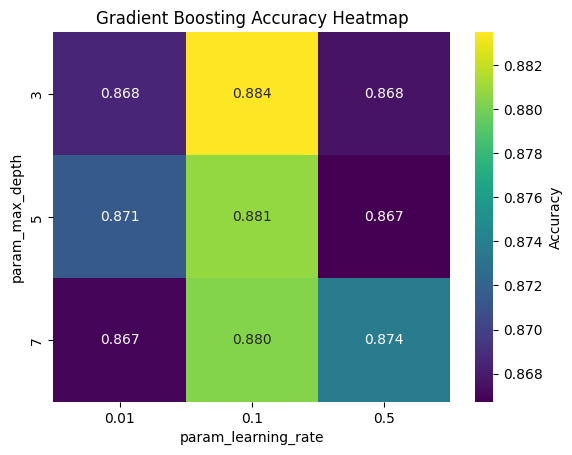

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, params, score_col='mean_test_score', cmap='viridis', title='Heatmap'):
    """ Function to plot a heatmap from GridSearchCV results, aggregating duplicate entries """
    # Group by the parameters and calculate mean scores
    pivot_data = data.groupby(params).agg({score_col: 'mean'}).reset_index()
    pivot_table = pivot_data.pivot(index=params[0], columns=params[1], values=score_col)

    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap=cmap, cbar_kws={'label': 'Accuracy'})
    plt.title(title)
    plt.xlabel(params[1])
    plt.ylabel(params[0])
    plt.show()

# Assuming you have results in results_rf and results_gb DataFrames
print("Random Forest Hyperparameter Tuning Heatmap:")
plot_heatmap(results_rf, ['param_max_depth', 'param_n_estimators'], title='Random Forest Accuracy Heatmap')

print("Gradient Boosting Hyperparameter Tuning Heatmap:")
plot_heatmap(results_gb, ['param_max_depth', 'param_learning_rate'], title='Gradient Boosting Accuracy Heatmap')


In [ ]:

# Assuming you have accuracy scores from earlier evaluations
model_performance = {
    'Model': ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, knn.predict(X_test)),  # KNN accuracy
        accuracy_score(y_test, gnb.predict(X_test)),  # Naive Bayes accuracy
        accuracy_score(y_test, dtc.predict(X_test)),  # Decision Tree accuracy
        accuracy_score(y_test, rfc.predict(X_test)),  # Random Forest accuracy
        accuracy_score(y_test, gbc.predict(X_test))   # Gradient Boosting accuracy
    ]
}

# Create a DataFrame
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame
print("Model Performance Summary:")
print(performance_df)


Model Performance Summary:
               Model  Accuracy
0                KNN  0.875776
1        Naive Bayes  0.877019
2      Decision Tree  0.843478
3      Random Forest  0.895652
4  Gradient Boosting  0.889441
